## The French Fama 3-Factor Model

This little project attempts to practice my coding skills in python with an application highly relevant to quantative investing, an area I am increasingly interested in. 

The French Fama (1992) model similarly to the CAPM attempts to explain stock returns by building a regression model on different factors. The three factors of the french fama model are market excess return, outperformance of small versus large companies based on market capitalization and outperformance of high book/market versus low book/market companies. 

$$
r = R_f + \beta\,(R_m - R_f) + b_s\,\mathrm{SMB} + b_v\,\mathrm{HML} + \alpha
$$

French Fama find that those three factors explain 90% of all portfolio's returns in contrast to 70% for the CAPM. 


In this project I will use the French Fama model to explain and predict Alphabet's stock returns. My proeject and the code is inspired and partially copied from fischerleben's project titled "Algorithmic Trading Project".






Let's start this project by importing all necessary libraries for this project:

In [123]:
# Initial Imports:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# To run models:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from joblib import dump, load

# For visualizations:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
%matplotlib inline


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


To estimate Alphabet's stock returns with the French Fama specification, we need data on the three factors. I took the historic monthly data from the French Fama website and imported them in the following:


In [124]:
import re, io
import pandas as pd

def read_kf_monthly(path):
    # Read raw lines 
    with open(path, "r", encoding="latin-1") as f:
        lines = f.readlines()

    # Find the first monthly data row (YYYYMM,...)
    start_data = None
    for i, ln in enumerate(lines):
        if re.match(r"^\s*\d{6}\s*,", ln):
            start_data = i
            break
    if start_data is None:
        raise ValueError("Could not find a YYYYMM data row.")

    # The header line is usually right above the first data row
    header_idx = start_data - 1

    # Find the end of the monthly block (until a blank/new section line)
    end_data = None
    for j in range(start_data, len(lines)):
        # stop when the line is not a YYYYMM row anymore and not empty continuation
        if not re.match(r"^\s*\d{6}\s*,", lines[j]) and lines[j].strip() != "":
            end_data = j
            break
        # or stop on a completely blank line (before Annual/Daily sections)
        if lines[j].strip() == "":
            end_data = j
            break
    if end_data is None:
        end_data = len(lines)

    # Build a clean CSV (header + data rows only)
    csv_block = "".join([lines[header_idx]] + lines[start_data:end_data])
    df = pd.read_csv(io.StringIO(csv_block), engine="python")
    df.columns = [c.strip() for c in df.columns]

    # Normalize date and index
    if "Date" not in df.columns:
        df = df.rename(columns={df.columns[0]: "Date"})
    df["Date"] = pd.to_datetime(df["Date"].astype(str), format="%Y%m")
    df = df.set_index("Date").sort_index()

    return df

# usage
french = read_kf_monthly("F-F_Research_Data_Factors.csv")
print(french.head())


            Mkt-RF   SMB   HML    RF
Date                                
1926-07-01    2.89 -2.55 -2.39  0.22
1926-08-01    2.64 -1.14  3.81  0.25
1926-09-01    0.38 -1.36  0.05  0.23
1926-10-01   -3.27 -0.14  0.82  0.32
1926-11-01    2.54 -0.11 -0.61  0.31


Now, I would like to regress Alphabet's monthly stock returns against our factors, so I am importing google's monthly stock prices in Euro. 

In [125]:
alphabet = pd.read_excel("Alphabet Inc._StockChart_08_29_2025.xlsx", sheet_name="Data")
alphabet.head()

,Pricing Date,GOOGL | Share Price (Monthly)(€),GOOGL | Volume (Monthly)
0,2025-08-28,181.481300,32339307
1,2025-07-31,167.758980,51329163
2,2025-06-30,150.059845,63378856
3,2025-05-30,151.354462,52639911
4,2025-04-30,139.966320,34981059


Next, I merge the two data frames:

In [155]:
import pandas as pd

# --- Ensure Fama–French is monthly-indexed ---
ff = french.copy()
ff.index = pd.to_datetime(ff.index)
ff.index = ff.index.to_period("M")   # YYYY-MM monthly period

# --- Clean & index the Alphabet data ---
alphabet_clean = (
    alphabet.rename(columns={
        "Pricing Date": "Date",
        "GOOGL | Share Price (Monthly)(€)": "GOOGL_Price_EUR",
        "GOOGL | Volume (Monthly)": "GOOGL_Volume"
    })
    .assign(Date=lambda d: pd.to_datetime(d["Date"]))
    .set_index("Date")
    .sort_index()
)

# Convert to monthly period index and ensure one row per month
alphabet_clean.index = alphabet_clean.index.to_period("M")
alphabet_clean = alphabet_clean[~alphabet_clean.index.duplicated(keep="last")]

# --- Join on the monthly index ---
combined_df = ff.join(alphabet_clean[["GOOGL_Price_EUR", "GOOGL_Volume"]], how="inner")

# Drop RF if you don't need it
combined_df = combined_df.drop(columns=["GOOGL_Volume"])

# Preview
combined_df.head()


,Mkt-RF,SMB,HML,RF,GOOGL_Price_EUR
Date,,,,,
2004-08,0.07,-1.52,1.08,0.11,2.105239
2004-09,1.60,3.01,-0.05,0.11,2.607552
2004-10,1.42,0.13,-0.26,0.11,3.745123
2004-11,4.53,3.74,1.57,0.15,3.430778
2004-12,3.42,-0.03,-0.23,0.16,3.559867


Here I convert Alphabet's monthly stock prices into monthly returns:

In [156]:

# make sure we're sorted by month
combined_df = combined_df.sort_index()

# simple arithmetic monthly return from month-end prices
combined_df["GOOGL_Ret"] = combined_df["GOOGL_Price_EUR"].astype(float).pct_change()

# drop the first NaN return row if you like
combined_df = combined_df.dropna(subset=["GOOGL_Ret"])

combined_df.head()


,Mkt-RF,SMB,HML,RF,GOOGL_Price_EUR,GOOGL_Ret
Date,,,,,,
2004-09,1.60,3.01,-0.05,0.11,2.607552,0.238601
2004-10,1.42,0.13,-0.26,0.11,3.745123,0.436260
2004-11,4.53,3.74,1.57,0.15,3.430778,-0.083934
2004-12,3.42,-0.03,-0.23,0.16,3.559867,0.037627
2005-01,-2.75,-1.66,2.06,0.16,3.745634,0.052184


Two build the model I define my Y and X variables. My Y variable is clearly Alphabet's stock returns why my X variables or predictors are the French Fama factors. 

In [158]:
# Define X and y variables:
X = combined_df.drop('GOOGL_Ret', axis=1)
X = X.drop('GOOGL_Price_EUR',axis=1)
y = combined_df.loc[:, 'GOOGL_Ret']

Then, I split my data into a training data set which is 80% of the total data frame and a test data set which is the remaining 20% of the data frame. That way I can use the model trained on the 80% of the model to test it on the remaining 20%. Moreover, I can use the model to build a trading algorithm that I can then use on teh 20% to test. 

In [159]:
# Split into Training/Testing Data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
price_test=combined_df["GOOGL_Price_EUR"][split:]
price_test

Date
2021-05     96.689771
2021-06    102.970284
2021-07    113.574439
2021-08    122.587722
2021-09    115.335653
2021-10    128.030181
2021-11    125.891462
2021-12    127.368364
2022-01    120.798965
2022-02    120.268258
2022-03    125.188564
2022-04    108.278505
2022-05    106.037560
2022-06    104.234006
2022-07    114.040128
2022-08    107.451638
2022-09     97.543870
2022-10     95.577963
2022-11     97.930003
2022-12     82.556811
2023-01     91.001988
2023-02     84.836520
2023-03     95.473092
2023-04     97.260774
2023-05    115.288921
2023-06    109.645200
2023-07    120.430128
2023-08    125.548740
2023-09    123.636528
2023-10    117.441720
2023-11    121.516757
2023-12    126.377543
2024-01    129.130170
2024-02    128.089346
2024-03    139.730994
2024-04    152.231856
2024-05    159.062250
2024-06    170.000595
2024-07    158.502960
2024-08    147.711858
2024-09    148.701110
2024-10    157.592310
2024-11    160.130810
2024-12    182.844870
2025-01    196.287642
2025-

Here the model is specified. I use the classical OLS linear regression model to regress Alphabet's stock returns onto the French Fama factors. This model is then used to make stock return predictions based on the French Fama Factors in the test data set. 

In [160]:
# Import Linear Regression Model from SKLearn:
from sklearn.linear_model import LinearRegression

# Create, train, and predict model:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [161]:
# Convert y_test to a dataframe:
y_test = y_test.to_frame()

The Predictions based on the French Fama model can then be compared to the actual stock returns. This can serve as a signal for buying or selling. If the predicted returns are higher than the actual returns, then this is a signal to buy, assuming that your own predictions are not priced in yet. Contrarely, if your prediction is lower than actual returns it's a sign sell. This is a only long strategy. Other specifications could look at short selling as well. 

In [162]:
signals_df = y_test.copy()

# Add "predictions" to dataframe:
y_test['Predictions'] = predictions
y_test["GOOGL_Price_EUR"]=price_test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['GOOGL_Ret'], 1.0,0.0)

# Drop nulls:
y_test=y_test.dropna()

y_test.head()

,GOOGL_Ret,Predictions,GOOGL_Price_EUR,Buy Signal
Date,,,,
2021-05,-0.011587,-0.014482,96.689771,0.0
2021-06,0.064955,0.065896,102.970284,1.0
2021-07,0.102983,0.039148,113.574439,0.0
2021-08,0.079360,0.039100,122.587722,0.0
2021-09,-0.059158,-0.047965,115.335653,1.0


The following code creates and algorithm that trades alphabet stocks based on the signals from the prediction models and looks at the portfolio's performance. 

In [163]:
# Define function to generate signals dataframe for algorithm:
def generate_signals(input_df, start_capital=100000, share_count=2000):
  # Set initial capital:
  initial_capital = float(start_capital)

  signals_df = input_df.copy()

  # Set the share size:
  share_size = share_count

  # Take a 500 share position where the Buy Signal is 1 (prior day's predictions greater than prior day's returns):
  signals_df['Position'] = share_size * signals_df['Buy Signal']

  # Make Entry / Exit Column:
  signals_df['Entry/Exit']=signals_df["Buy Signal"].diff()

  # Find the points in time where a 500 share position is bought or sold:
  signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

  # Multiply share price by entry/exit positions and get the cumulative sum:
  signals_df['Portfolio Holdings'] = signals_df['GOOGL_Price_EUR'] * signals_df['Entry/Exit Position'].cumsum()

  # Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio:
  signals_df['Portfolio Cash'] = initial_capital - (signals_df['GOOGL_Price_EUR'] * signals_df['Entry/Exit Position']).cumsum()

  # Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments):
  signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

  # Calculate the portfolio daily returns:
  signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

  # Calculate the cumulative returns:
  signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

  signals_df = signals_df.dropna()
  
  return signals_df

The following data frame shows the portfolio development over time, including entry and exit from the alphabet, the portfolio's cash position, the portfolio's total value, daily return and cumulative returns. 

In [164]:
# Generate and view signals dataframe using generate signals function
signals_df=generate_signals(y_test)
signals_df.head(10)

,GOOGL_Ret,Predictions,GOOGL_Price_EUR,Buy Signal,Position,Entry/Exit,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2021-07,0.102983,0.039148,113.574439,0.0,0.0,-1.0,-2000.0,0.0000,121208.3104,121208.3104,0.212083,0.212083
2021-08,0.079360,0.039100,122.587722,0.0,0.0,0.0,0.0,0.0000,121208.3104,121208.3104,0.000000,0.212083
2021-09,-0.059158,-0.047965,115.335653,1.0,2000.0,1.0,2000.0,230671.3056,-109462.9952,121208.3104,0.000000,0.212083
2021-10,0.110066,0.075550,128.030181,0.0,0.0,-1.0,-2000.0,0.0000,146597.3664,146597.3664,0.209466,0.465974
2021-11,-0.016705,0.003183,125.891462,1.0,2000.0,1.0,2000.0,251782.9240,-105185.5576,146597.3664,0.000000,0.465974
2021-12,0.011732,0.029541,127.368364,1.0,2000.0,0.0,0.0,254736.7272,-105185.5576,149551.1696,0.020149,0.495512
2022-01,-0.051578,-0.083004,120.798965,0.0,0.0,-1.0,-2000.0,0.0000,136412.3720,136412.3720,-0.087855,0.364124
2022-02,-0.004393,-0.024100,120.268258,0.0,0.0,0.0,0.0,0.0000,136412.3720,136412.3720,0.000000,0.364124
2022-03,0.040911,0.049782,125.188564,1.0,2000.0,1.0,2000.0,250377.1270,-113964.7550,136412.3720,0.000000,0.364124


The following calculates the portfolio's anual return, cumulative returns, annual volatiliy, sharpe ratio and sortino ratio. By portfolio I mean the portfolio that follows the trading algorithm

In [165]:
def algo_evaluation(signals_df):
  # Prepare dataframe for metrics
  metrics = [
      'Annual Return',
      'Cumulative Returns',
      'Annual Volatility',
      'Sharpe Ratio',
      'Sortino Ratio']

  columns = ['Backtest']

  # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
  portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
  # Calculate cumulative returns:
  portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]
  # Calculate annualized returns:
  portfolio_evaluation_df.loc['Annual Return'] = (signals_df['Portfolio Daily Returns'].mean() * 252)
  # Calculate annual volatility:
  portfolio_evaluation_df.loc['Annual Volatility'] = (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))
  # Calculate Sharpe Ratio:
  portfolio_evaluation_df.loc['Sharpe Ratio'] = (signals_df['Portfolio Daily Returns'].mean() * 252) / (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))

  #Calculate Sortino Ratio/Downside Return:
  sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
  sortino_ratio_df.loc[:,'Downside Returns'] = 0

  target = 0
  mask = sortino_ratio_df['Portfolio Daily Returns'] < target
  sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
  down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
  expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
  sortino_ratio = expected_return/down_stdev

  portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio


  return portfolio_evaluation_df

In [166]:
# Generate Metrics for Algorithm:
algo_evaluation(signals_df)

,Backtest
Annual Return,7.202617
Cumulative Returns,1.082977
Annual Volatility,2.617188
Sharpe Ratio,2.752044
Sortino Ratio,4.912085


Next, I do the same for the portfolio which trades a normal long position (buy at t_0 and sell at t_n). That way I can evaluate different trading strategies in regards to the portfolio's return. 

In [167]:
# Define function to evaluate the underlying asset:
def underlying_evaluation(signals_df):
  underlying=pd.DataFrame()
  underlying["GOOGL_Price_EUR"]=signals_df["GOOGL_Price_EUR"]
  underlying["Portfolio Daily Returns"]=underlying["GOOGL_Price_EUR"].pct_change()
  underlying["Portfolio Daily Returns"].fillna(0,inplace=True)
  underlying['Portfolio Cumulative Returns']=(1 + underlying['Portfolio Daily Returns']).cumprod() - 1

  underlying_evaluation=algo_evaluation(underlying)

  return underlying_evaluation 

In [168]:
# Define function to return algo evaluation relative to underlying asset combines the two evaluations into a single dataframe
def algo_vs_underlying(signals_df):
  metrics = [
      'Annual Return',
      'Cumulative Returns',
      'Annual Volatility',
      'Sharpe Ratio',
      'Sortino Ratio']

  columns = ['Algo','Underlying']
  algo=algo_evaluation(signals_df)
  underlying=underlying_evaluation(signals_df)

  comparison_df=pd.DataFrame(index=metrics,columns=columns)
  comparison_df['Algo']=algo['Backtest']
  comparison_df['Underlying']=underlying['Backtest']

  return comparison_df

# Generate Metrics for Function vs. Buy-and-Hold Strategy:
algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,7.202617,2.222557
Cumulative Returns,1.082977,0.321247
Annual Volatility,2.617188,1.238204
Sharpe Ratio,2.752044,1.794985
Sortino Ratio,4.912085,2.740144


The results show that following the specified model the annual returns are significantly higher (7.5 % versus 2.2 %) which are significant gains. However, this comes at teh cost of higher volatility. Moreover, this excercise is limited in time scope, only uses monthly data and doesn't account for transaction costs from trades. 

In [169]:

# Define function which accepts daily signals dataframe and returns evaluations of individual trades:
def trade_evaluation(signals_df):
  
  #initialize dataframe
  trade_evaluation_df = pd.DataFrame(
    columns=[
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
  )
  
  
  entry_date = ''
  exit_date = ''
  entry_portfolio_holding = 0
  exit_portfolio_holding = 0
  share_size = 0
  entry_share_price = 0
  exit_share_price = 0

  # Loop through signal DataFrame
  # If `Entry/Exit` is 1, set entry trade metrics
  # Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
  # Then append the record to the trade evaluation DataFrame
  for index, row in signals_df.iterrows():
      if row['Entry/Exit'] == 1:
          entry_date = index
          entry_portfolio_holding = row['Portfolio Total']
          share_size = row['Entry/Exit Position']
          entry_share_price = row['GOOGL_Price_EUR']

      elif row['Entry/Exit'] == -1:
          exit_date = index
          exit_portfolio_holding = abs(row['Portfolio Total'])
          exit_share_price = row['GOOGL_Price_EUR']
          profit_loss = exit_portfolio_holding - entry_portfolio_holding
          trade_evaluation_df = trade_evaluation_df.append(
              {
                  'Entry Date': entry_date,
                  'Exit Date': exit_date,
                  'Shares': share_size,
                  'Entry Share Price': entry_share_price,
                  'Exit Share Price': exit_share_price,
                  'Entry Portfolio Holding': entry_portfolio_holding,
                  'Exit Portfolio Holding': exit_portfolio_holding,
                  'Profit/Loss': profit_loss
              },
              ignore_index=True)

  # Print the DataFrame
  return trade_evaluation_df

The following test looks at the model's specific parameter (coefficients, p-tests, R^2)

In [170]:

# Set X and y variables:
y = combined_df.loc[:, 'GOOGL_Ret']
X = combined_df.drop('GOOGL_Ret', axis=1)
X = X.drop('GOOGL_Price_EUR',axis=1)

# Add "Constant" column of "1s" to DataFrame to act as an intercept, using StatsModels:
X = sm.add_constant(X)

# Split into Training/Testing data:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Run Ordinary Least Squares (OLS )Model:
model = sm.OLS(y_test, X_test)
model_results = model.fit()
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              GOOGL_Ret   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     8.553
Date:                Sat, 30 Aug 2025   Prob (F-statistic):           3.20e-05
Time:                        14:17:17   Log-Likelihood:                 71.264
No. Observations:                  50   AIC:                            -132.5
Df Residuals:                      45   BIC:                            -123.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0171      0.016      1.059      0.2

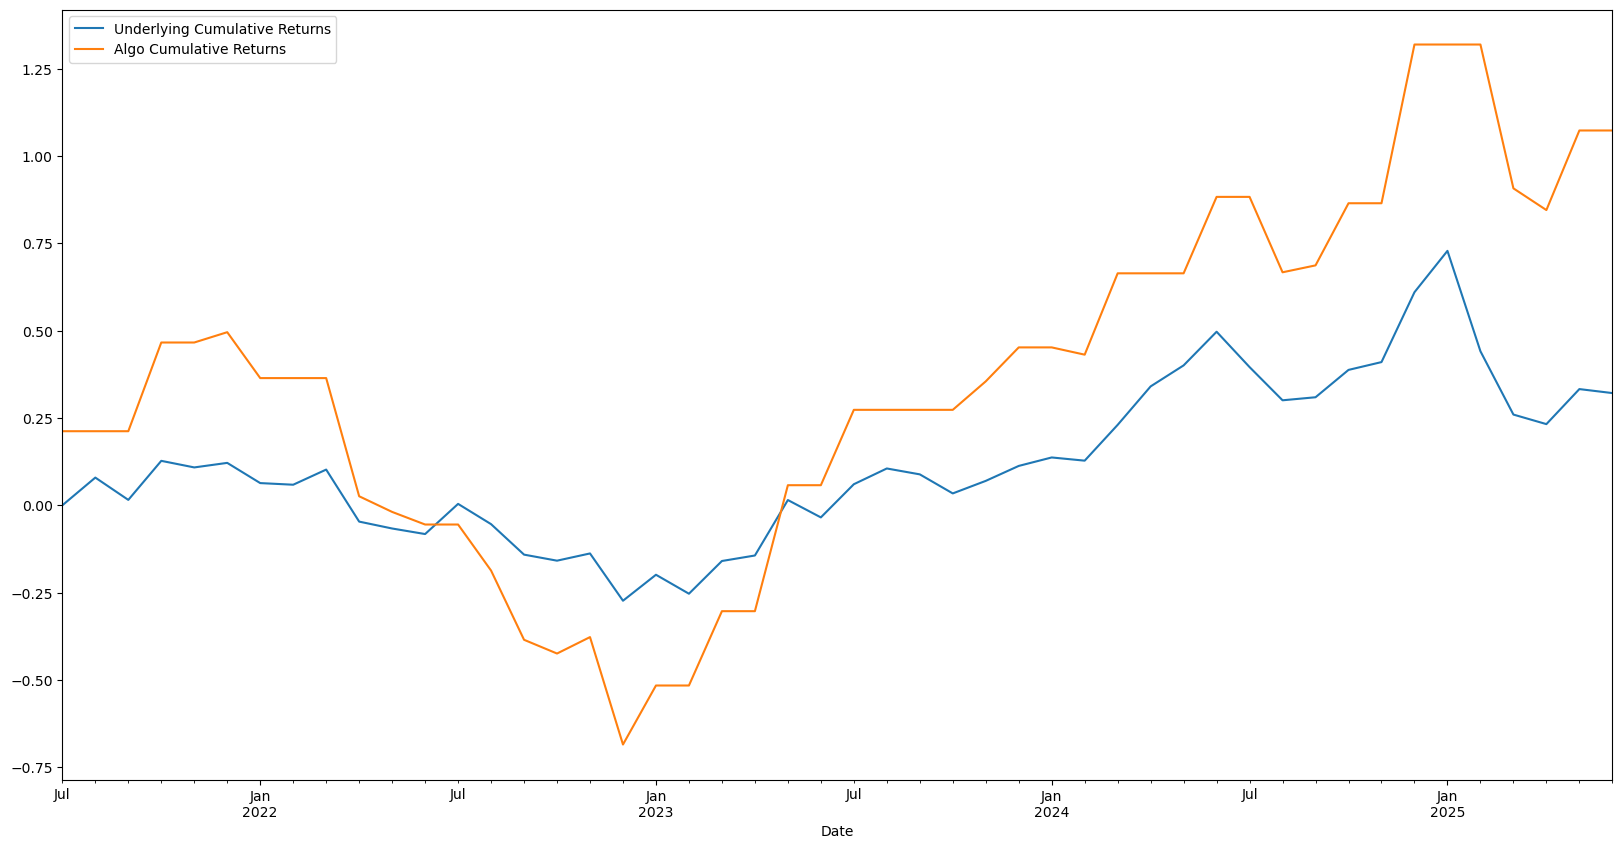

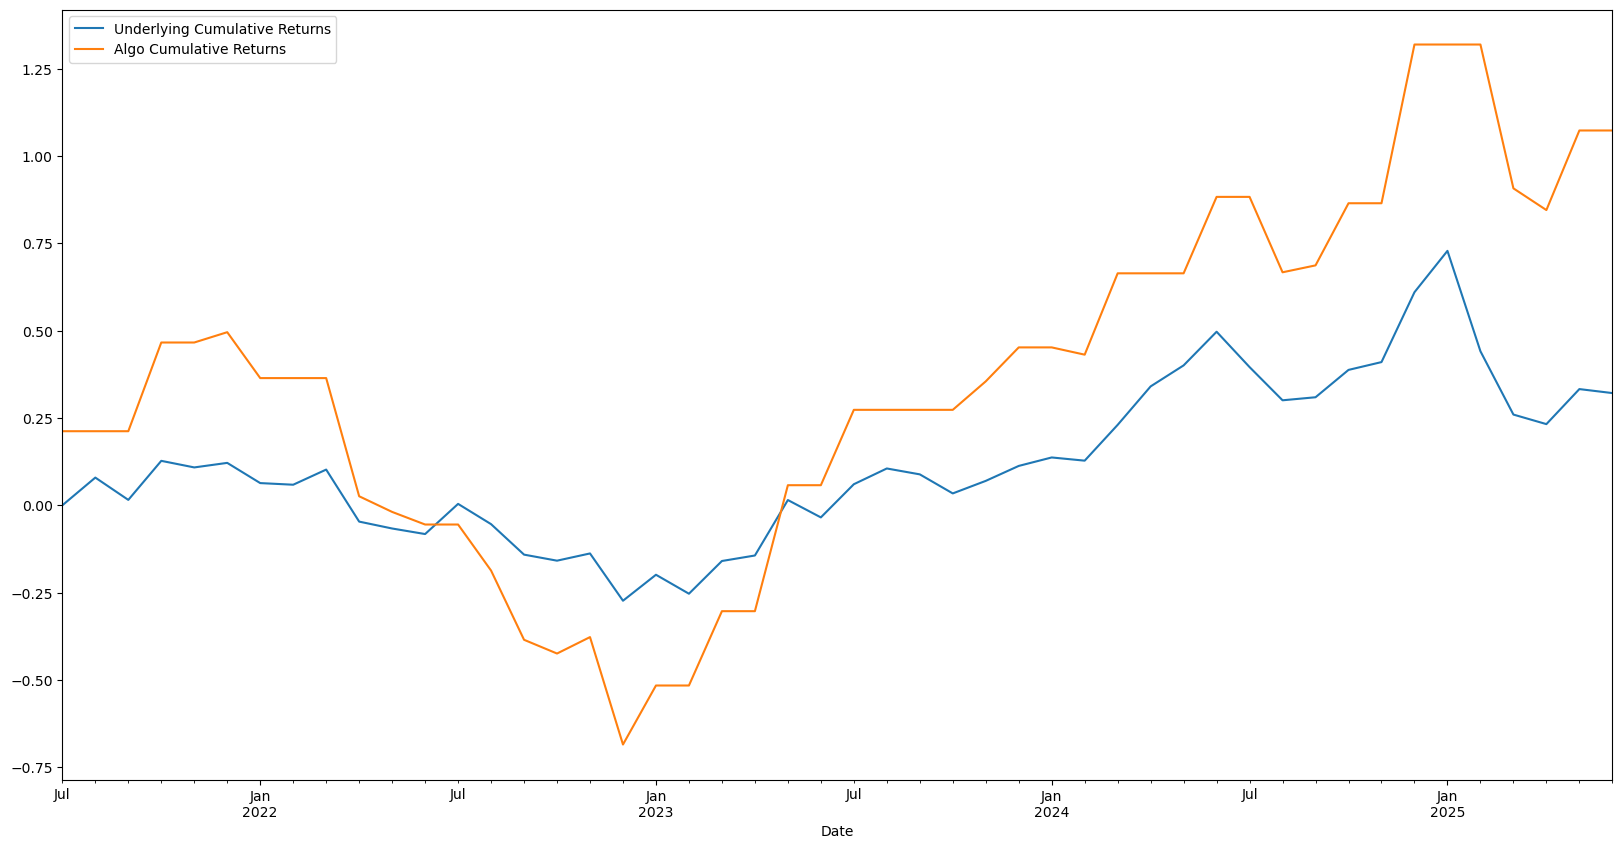

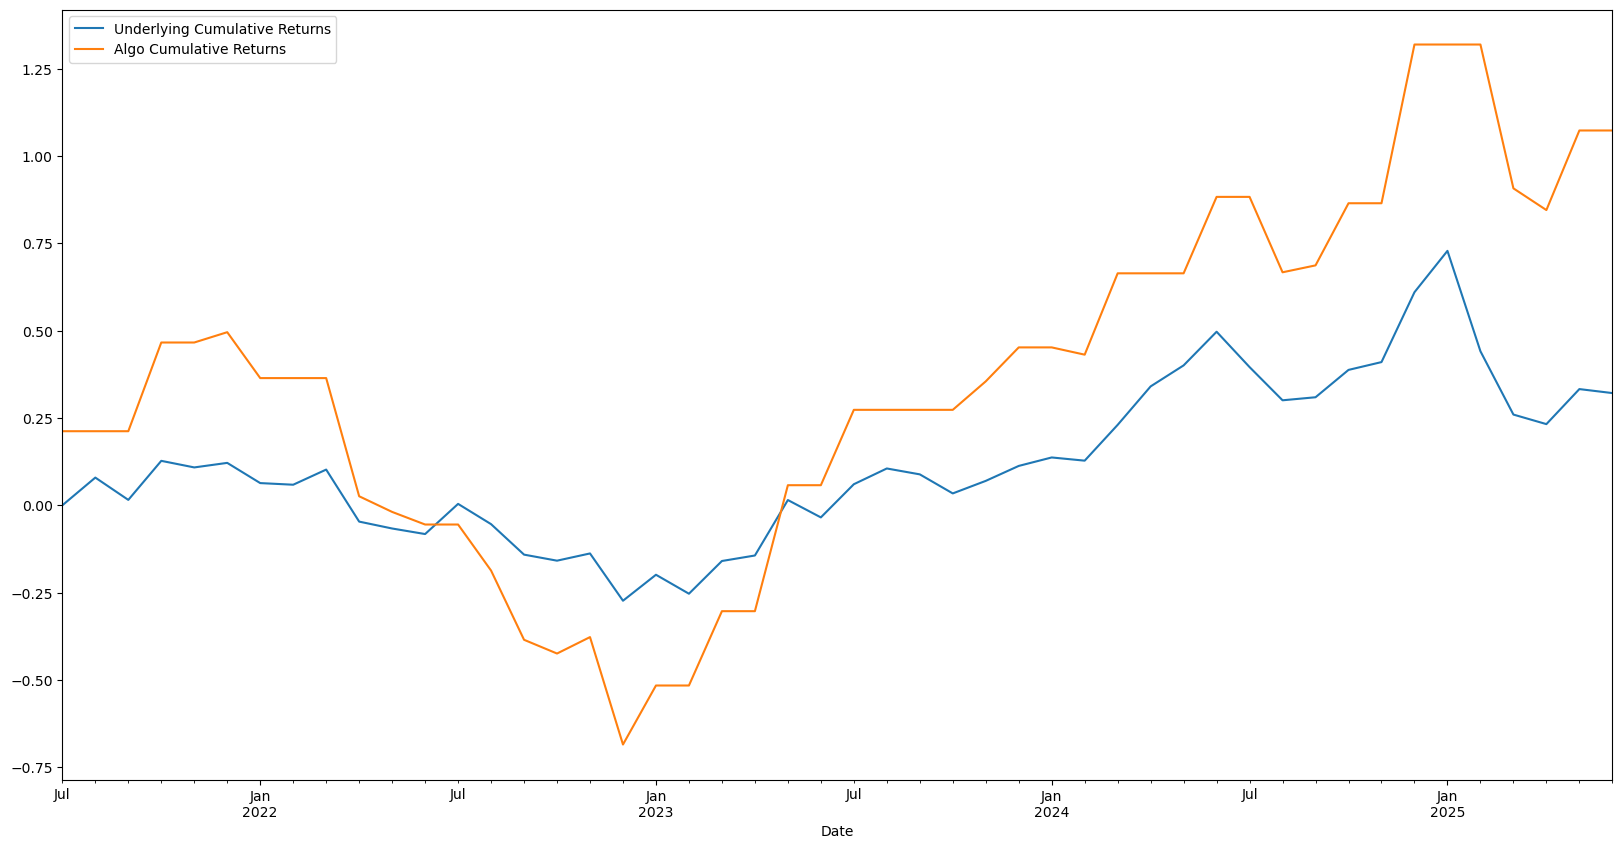

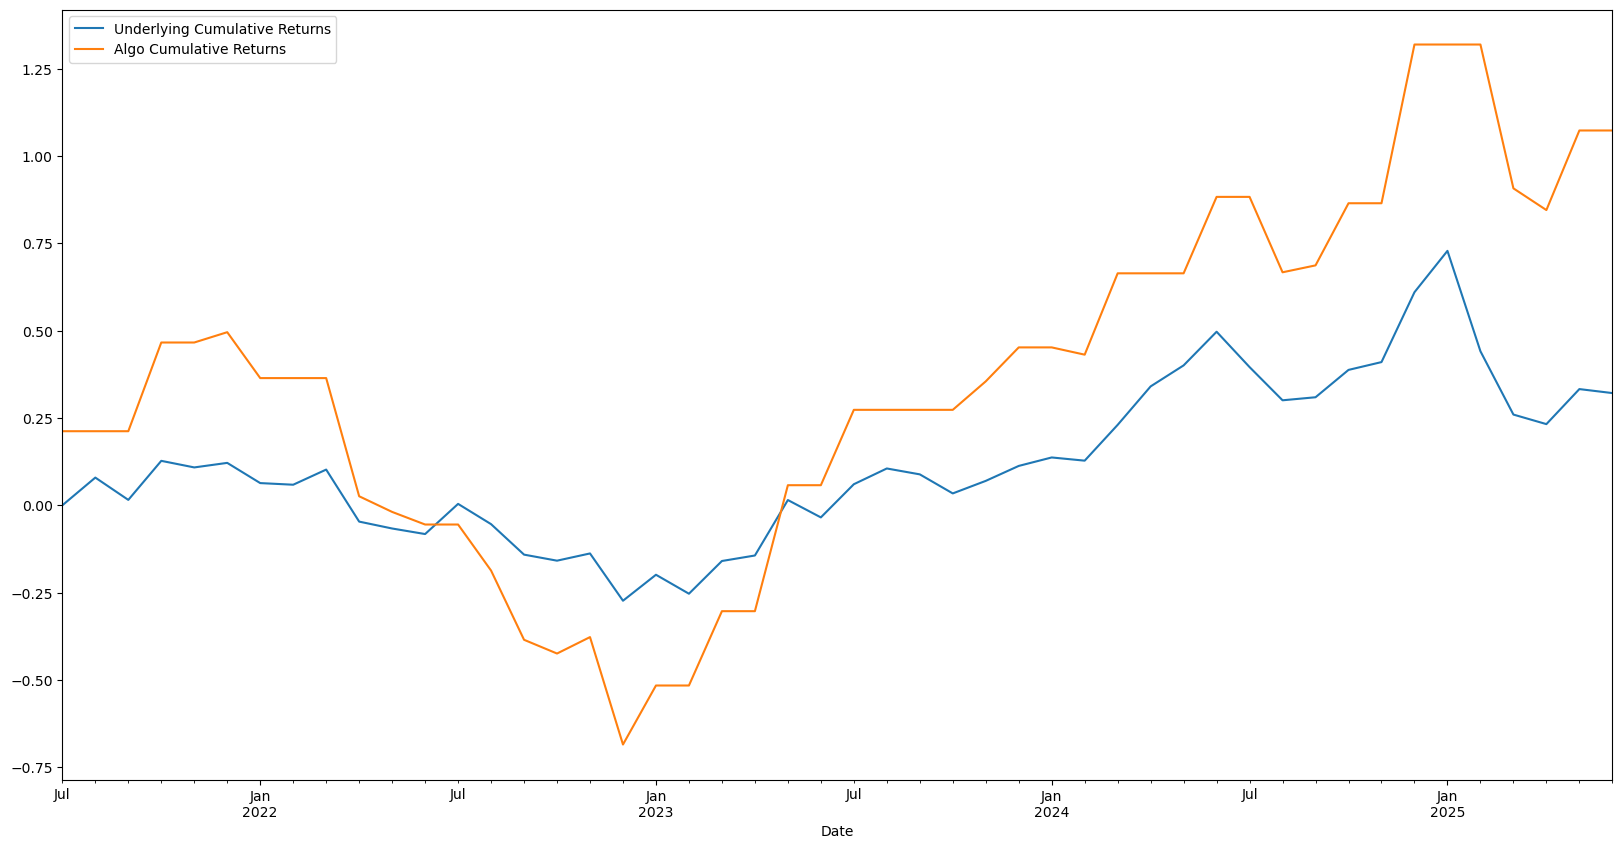

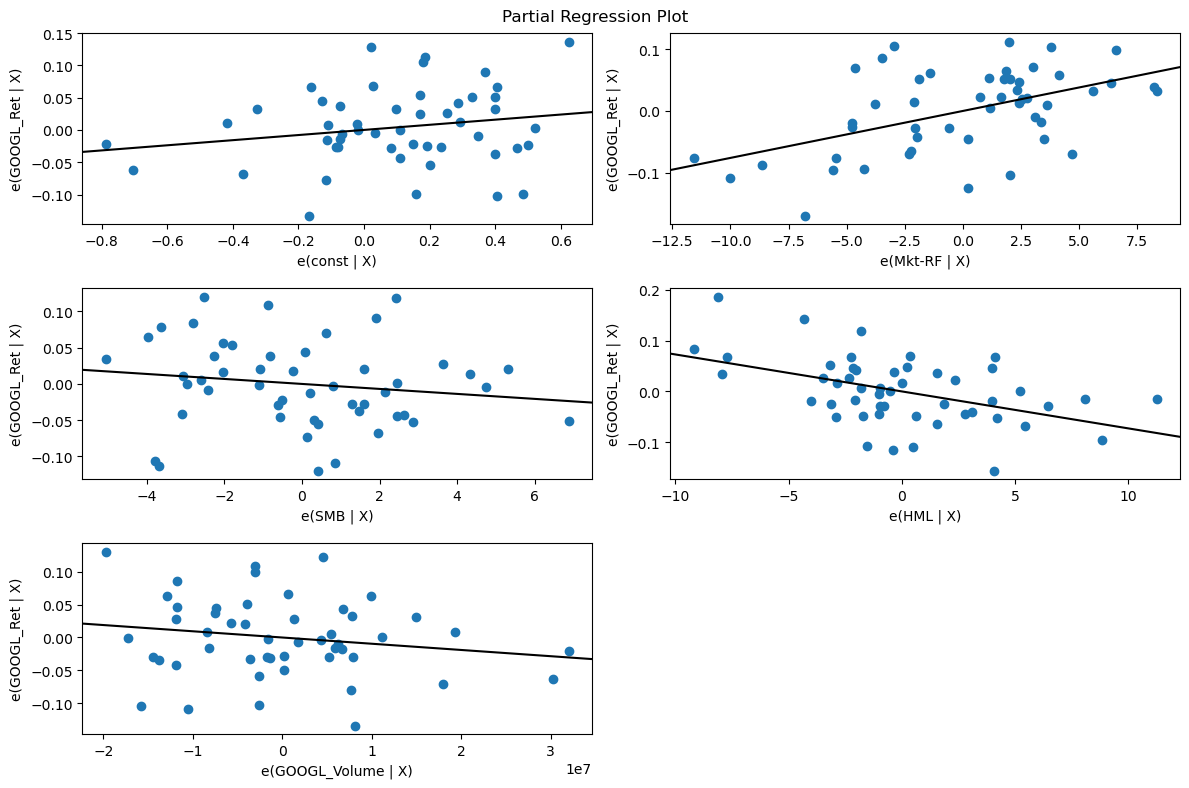

In [141]:
# Plot Partial Regression Plot:
fig = sm.graphics.plot_partregress_grid(model_results, fig = plt.figure(figsize=(12,8)))
plt.show()

The followin image plots the time series of predicted cumulative results versus actual cumulative results. 

In [142]:
# Define function that plots Algo Cumulative Returns vs. Underlying Cumulative Returns:
def underlying_returns(signals_df):
  underlying=pd.DataFrame()
  underlying["GOOGL_Price_EUR"]=signals_df["GOOGL_Price_EUR"]
  underlying["Underlying Daily Returns"]=underlying["GOOGL_Price_EUR"].pct_change()
  underlying["Underlying Daily Returns"].fillna(0,inplace=True)
  underlying['Underlying Cumulative Returns']=(1 + underlying['Underlying Daily Returns']).cumprod() - 1
  underlying['Algo Cumulative Returns']=signals_df["Portfolio Cumulative Returns"]

  graph_df=underlying[["Underlying Cumulative Returns", "Algo Cumulative Returns"]]

  return graph_df

In [143]:
# Generate Cumulative Return plot using above defined function:
underlying_returns(signals_df).plot(figsize=(20,10))

<Axes: xlabel='Date'>

Next, I would like to build a time lagged model, a FF 5 factor model and one model with more explanatory variables. I wanna use PCA for dimensionality reduction and maybe use ridge or lasso to practice some ML application. 